In [1]:
import os

import pandas as pd
import numpy as np
import math
from scipy.stats import beta, gamma

import matplotlib.pyplot as plt
import seaborn as sns

# AB Test Part 1: Modeling and analysis of rate metrics

For this example, we'll be using a dataset from the Diet product, but **the strategy would be the same for any rate metric and any product**. 

Any ETL or data cleaning have to be performed before running this notebook. For simplicity, we won't be doing that here, as the `csv` file in the data folder can be used, so be sure to have your data in the same shape if you're trying with other product's metrics.



## Context

Product team decided to make a change in the upsell flow of the plans for Diet. We hypothesize that the change will make **conversion rate** better. The first step to formalise the hypothesis is to model each conversion rate, $X$, as a Bernoulli (binomial) random variable with conversion probability $\theta$:

$$X \sim Ber(\theta)$$

$$p(X=1) = \theta$$

$$p(X=0) = 1 -\theta$$

And our next step will be to choose an appropriate approximation for this distribution using past data. This will be the **prior distribution of $\theta$**

Next, we'll set our **loss threshold**, which is the largest expected loss we're willing to accept if we were to make a mistake when choosing a winner. The loss threshold allows us to say that even if we did draw the wrong conclusions, we can be confident that the conversion rate wouldn't drop more than we're comfortable with. 

Last step will be to draw samples in a randomised experiment (*the ab test itself*) and use them to update the distribution, and our certainty, about $\theta$.

In [2]:
# get historical data from previous week
df_prior_data = pd.read_csv(os.path.join('../data/external', 'prior_data_cr.csv'), index_col=0)

print(df_prior_data.head())
print(df_prior_data.shape)

                             session_id  converted
0  9d7e7eb0-51b7-11eb-8260-5f9daf0a778a          0
1  9de6d810-5415-11eb-a8fc-f726e66bec66          0
2  811b4650-544f-11eb-a0a0-6179589e48d9          0
3  f5722f30-53b1-11eb-a585-cf5fe015baf0          0
4  52a467f0-5064-11eb-8725-8796151a24ab          0
(126011, 2)


In [3]:
conversion_rate = df_prior_data['converted'].sum() / len(df_prior_data)
print(f'Baseline conversion rate: {round(conversion_rate, 3)}')

Baseline conversion rate: 0.02


#### Choosing a prior

We can see the baseline conversion rate, taken from a sample of users during the previous week of the experiment, is about 2%. 

Next, we need to choose a prior distribution for $\theta$. For now, at this point, we'll use the [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) for two main reasons: it's a flexible distribution over $[0, 1]$, and is also a good [conjugate prior](https://en.wikipedia.org/wiki/Conjugate_prior). In these kinds of settings, using Beta distributions is common practice.

When choosing a prior distribution for our metrics, in this case our conversion rate, the best practice is to choose a weaker prior than the data suggests. 

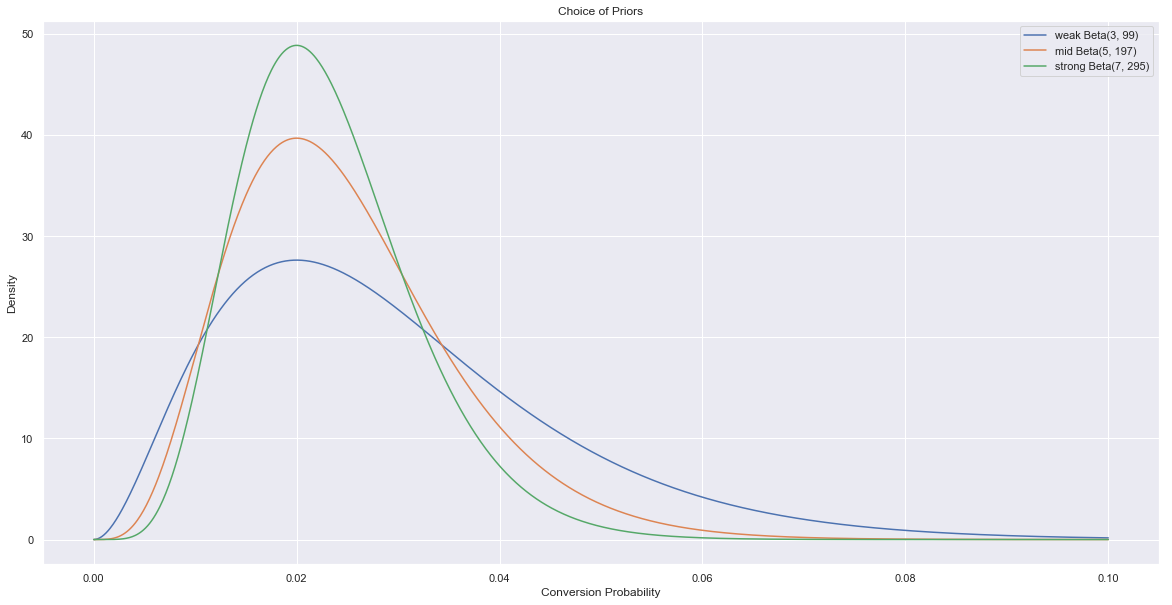

In [4]:
sns.set(rc={'figure.figsize':(20,10)})

fig, ax = plt.subplots(1, 1)

# start, stop and number of samples to generate distribution
x = np.linspace(0, 0.1, 1000) 

# beta distributions
beta_weak = beta(int(round(conversion_rate, 2)*100)+1, 100+1-int(round(conversion_rate, 2)*100))
beta_mid = beta(int(round(conversion_rate, 2)*200)+1, 200+1-int(round(conversion_rate, 2)*200))
beta_strong = beta(int(round(conversion_rate, 3)*300)+1, 300+1-int(round(conversion_rate, 3)*300))

ax.plot(x, beta_weak.pdf(x),
        label=f'weak Beta({int(round(conversion_rate, 2)*100)+1}, {100+1-int(round(conversion_rate, 2)*100)})')

ax.plot(x, beta_mid.pdf(x),
       label=f'mid Beta({int(round(conversion_rate, 2)*200)+1}, {200+1-int(round(conversion_rate, 2)*200)})')

ax.plot(x, beta_strong.pdf(x),
       label=f'strong Beta({int(round(conversion_rate, 3)*300)+1}, {300+1-int(round(conversion_rate, 3)*300)})')

ax.set_xlabel('Conversion Probability')
ax.set_ylabel('Density')
ax.set_title('Choice of Priors')
ax.legend();

Remember that:

$$Posterior \propto prior\cdot likelihood$$

If we chose too strong a distribution, the likelihood would have too much force in the posterior, but if we chose the distribution to be too weak, the prior would have too much effect on the posterior. The idea is to always be in the middle.

We'll choose a prior between the weakest and the mid prior shown above:

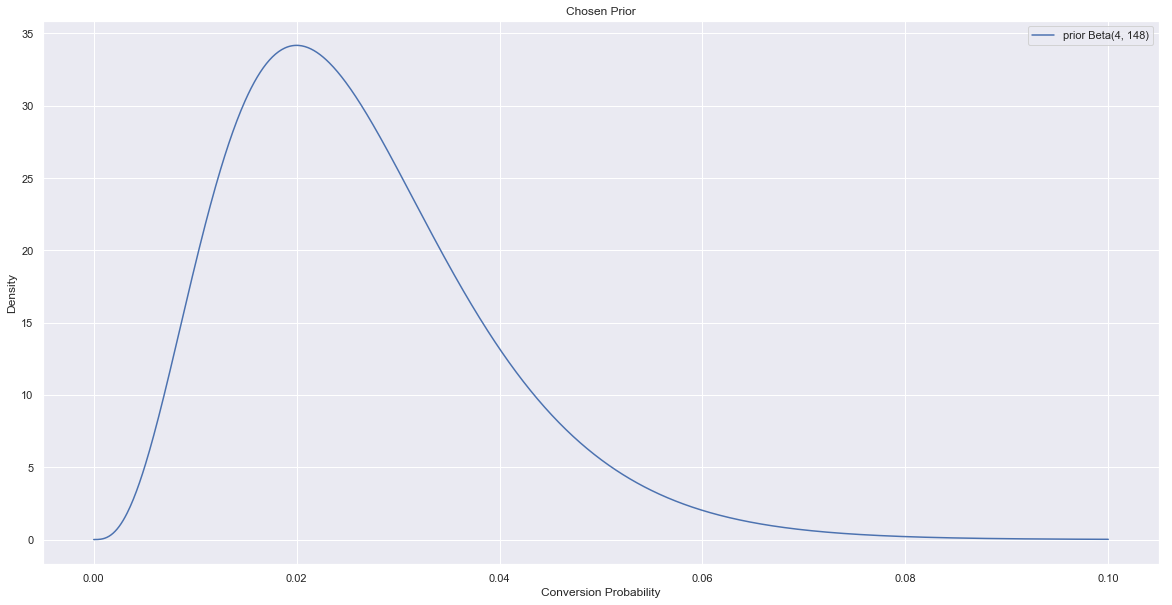

In [5]:
# set alpha & beta priors
prior_alpha = round(conversion_rate, 2)*150 + 1
prior_beta = 150 + 1 - round(conversion_rate, 2)*150
prior = beta(prior_alpha, prior_beta)

fig, ax = plt.subplots(1, 1)

x = np.linspace(0,0.1,1000)

ax.plot(x, prior.pdf(x), 
        label=f'prior Beta({int(round(conversion_rate, 2)*150) + 1}, {150 + 1 - int(round(conversion_rate, 2)*150)})')

ax.set_xlabel('Conversion Probability')
ax.set_ylabel('Density')
ax.set_title('Chosen Prior')
ax.legend();

#### Setting a loss threshold

With a chosen prior, let's now choose our $\epsilon$, which is the highest expected loss we're willing to accept should we make the mistake of choosing the wrong variant. Let's assume product department decides that this relative loss can be 20%



In [6]:
epsilon = conversion_rate * 0.3
print(f'Loss threshold: {epsilon}')

Loss threshold: 0.005975668790819849


#### The experiment

We had the **split running for two weeks**, and now we want to draw conclusions from it. 

In order to do this, we'll need to: 
1.  Use the experiment data and our prior to calculate the posterior distributions. 
2.  Calculate the probability of each variant being better
3.  Calculate the expected loss of wrongly choosing a variant.

Again, if you're running this notebook with your own data, maybe from Dating, VR or any other product, make sure yours is the same shape and logic:

In [7]:
df_experiment_data = pd.read_csv(os.path.join('../data/external', 'experiment_data_cr.csv'), index_col=0)

print(df_experiment_data.head())
print(df_experiment_data.shape)

                              session_id      group  converted
0   1d6bf6b0-5de9-11eb-84ff-e13d0a529a5d    control          0
2   99665250-5f34-11eb-8b64-652bb6889046    control          0
11  65301aa0-64bd-11eb-a175-95bd70510172    control          0
12  7d0ac920-5dfd-11eb-9b10-1992247d2157    control          0
21  68134840-60ea-11eb-96a0-99f53f37b6b1  treatment          0
(494038, 3)


In [8]:
results = df_experiment_data.groupby('group').agg({'session_id': pd.Series.nunique,
                                                   'converted': sum})

results.rename({'session_id': 'sample_size'}, axis=1, inplace=True)

results['conversion_rate'] = results['converted'] / results['sample_size']

print(results)

           sample_size  converted  conversion_rate
group                                             
control         190447       3373         0.017711
treatment       180753       3578         0.019795


It's quite apparent from the above aggregation that treatment seemed to perform better. In any case, we need to perform further calculations in order to update our beliefs (priors) about conversion probabilities $\theta_{c}$ and $\theta_{t}$

### 1. Posteriors

In [9]:
control = beta(prior_alpha + results.loc['control', 'converted'], \
               prior_beta + results.loc['control', 'sample_size'] - results.loc['control', 'converted'])

treatment = beta(prior_alpha + results.loc['treatment', 'converted'],\
                 prior_beta + results.loc['treatment', 'sample_size'] - results.loc['treatment', 'converted'])

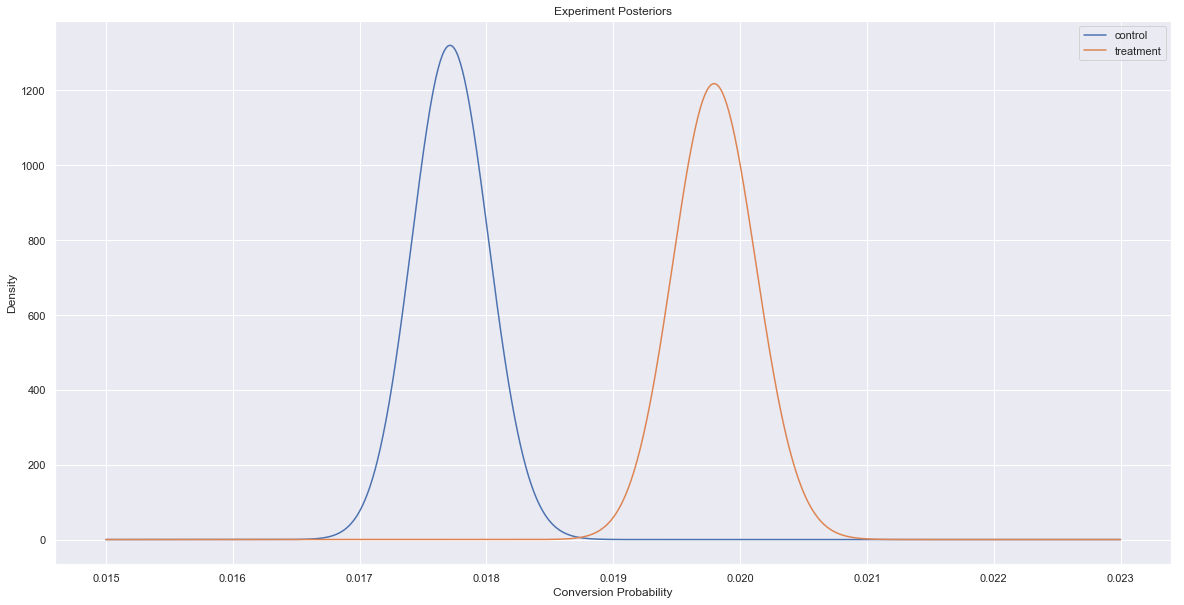

In [10]:
fig, ax = plt.subplots()

x = np.linspace(0.015, 0.023, 1000)

ax.plot(x, control.pdf(x), label='control')
ax.plot(x, treatment.pdf(x), label='treatment')

ax.set_xlabel('Conversion Probability')
ax.set_ylabel('Density')
ax.set_title('Experiment Posteriors')
ax.legend();

Now that we have calculated our posteriors, we can go ahead on the joint posterior. In randomised experiments, by definition, users are assigned randomly to a variant, so we can assume the posterior distributions are independent. 

#### Joint posterior

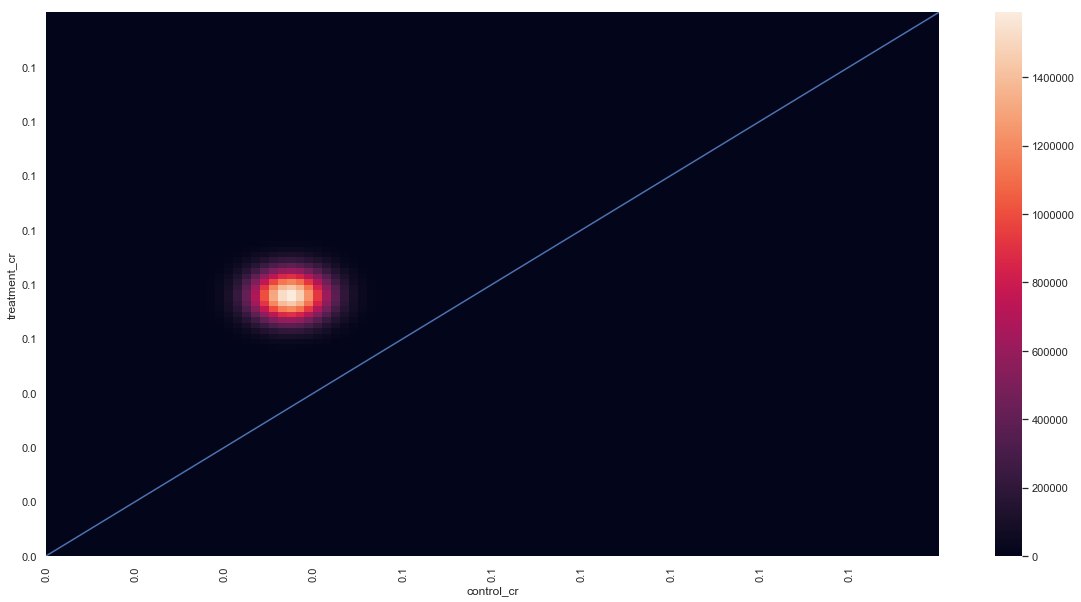

In [11]:
joint_dist_for_plot = []

for i in np.linspace(0.015, 0.025, 100):
    for j in np.linspace(0.015, 0.025, 100):
        joint_dist_for_plot.append([i, j, control.pdf(i) * treatment.pdf(j)])
        

joint_dist_for_plot = pd.DataFrame(joint_dist_for_plot)

joint_dist_for_plot.rename({0: 'control_cr',
                            1: 'treatment_cr',
                            2: 'joint_density'}, axis=1, inplace=True)

tick_locations = range(0, 100, 10)
tick_labels = [round(0.015 + i*0.01, 1) for i in range(16)]

df_heatmap = pd.pivot_table(joint_dist_for_plot, values='joint_density', index='treatment_cr', columns='control_cr')

ax = sns.heatmap(df_heatmap)
ax.set_xticks(tick_locations)
ax.set_xticklabels(tick_labels)
ax.set_yticks(tick_locations)
ax.set_yticklabels(tick_labels)
ax.plot([0, 1], [0, 1], transform=ax.transAxes)
ax.invert_yaxis()

The diagonal from bottom left to top right represents $\theta_{c} = \theta_{t}$, that is, the boundary between control and treatment. If the probability spot was perfectly shared by the two variants, that would mean no variant is better than the other.

The visual representation is intuitive, but we also need to quantify that intuition. We'll calculate $p(\theta_{t}\geq\theta_{c})$ and $E[L](t)$, the expected loss of choosing a wrong variant.

#### Probability of treatment being better

In [12]:
import decimal

decimal.getcontext().prec = 4

control_simulation = np.random.beta(
    prior_alpha + results.loc['control', 'converted'], prior_beta +\
    results.loc['control', 'sample_size'] - results.loc['control', 'converted'], size=10000)

treatment_simulation = np.random.beta(
    prior_alpha + results.loc['treatment', 'converted'], prior_beta +\
    results.loc['treatment', 'sample_size'] - results.loc['treatment', 'converted'], size=10000)

treatment_won = [i <= j for i,j in zip(control_simulation, treatment_simulation)]
chance_of_beating_control = np.mean(treatment_won)

print(f'Chance of treatment beating control is {decimal.getcontext().create_decimal(chance_of_beating_control)}')

Chance of treatment beating control is 1


#### Loss function for each variant

In [13]:
decimal.getcontext().prec = 4

loss_control = [max(j - i, 0) for i,j in zip(control_simulation, treatment_simulation)]
loss_treatment = [max(i - j, 0) for i,j in zip(control_simulation, treatment_simulation)]
all_loss_control = [int(i)*j for i,j in zip(treatment_won, loss_control)]
all_loss_treatment = [(1 - int(i))*j for i,j in zip(treatment_won, loss_treatment)]
expected_loss_control = np.mean(all_loss_control)
expected_loss_treatment = np.mean(all_loss_treatment)

print(f'Expected loss of choosing control: {decimal.getcontext().create_decimal(expected_loss_control)}\n\
Expected loss of choosing treatment: {decimal.getcontext().create_decimal(expected_loss_treatment)}')

Expected loss of choosing control: 0.002087
Expected loss of choosing treatment: 0


In [14]:
if expected_loss_treatment < epsilon or expected_loss_control < epsilon:
    print(f'Test reached significance')
else:
    print(f'No variant is below loss threshold')

Test reached significance


We can conclude with **high confidence that the treatment is better**, and that the **expected cost of mistakenly choosing treatment would not be greater than what we’re comfortable with**. So we can strongly recommend that the treatment variant should be rolled out to the rest of our user base.
